In [1]:
using Distributions
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!
using Base.Iterators: repeated, partition
using LinearAlgebra: norm
using CounterfactualExplanations
using Distances
using BSON
using MLDatasets

include("../src/utils/train.jl")
include("../src/utils/plot.jl")
include("../src/utils/evaluate.jl")

evaluate_model (generic function with 1 method)

In [2]:
X, y = load_mnist()
X = (X .+ 1) ./ 2

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [3]:
X = reshape(X, 28, 28, 1, 60000)

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [4]:
X

28×28×1×60000 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  

In [5]:
size(X)

(28, 28, 1, 60000)

In [6]:
function margin_loss(logits, y)
    y = onehotbatch(y, 0:9) 
    preds_correct_class = sum(logits.*y, dims=1)
    diff = preds_correct_class .- logits
    diff[y] .= Inf
    margin = minimum(diff, dims=1)
    return margin
end

function cross_entropy_loss(logits, y)
    return -sum(onehotbatch(y, 0:9) .* logsoftmax(logits; dims=1); dims=1)
end

cross_entropy_loss (generic function with 1 method)

In [7]:
m = BSON.load("../src/models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
clean_m = BSON.load("../src/models/MNIST/clean_20ep_32bs.bson")[:model]

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 397.789 KiB.

In [8]:
CNN() = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10)) |> gpu

model = CNN();
loss(x, y) = logitcrossentropy(x, y)
opt = ADAM()

vanilla_losses = vanilla_train(model, loss, opt, X, y, 5, 32, 0, 9)

┌ Info: The CUDA functionality is being called but
│ `CUDA.jl` must be loaded to access it.
│ Add `using CUDA` or `import CUDA` to your code.
└ @ Flux C:\Users\Hp\.julia\packages\Flux\Wz6D4\src\functor.jl:349


Epoch: 1
Average loss: 0.19319827362882594
Epoch: 2
Average loss: 0.06288169089402072


Progress:  40%|█████████████████                        |  ETA: 0:03:57

Epoch: 3


Progress:  60%|█████████████████████████                |  ETA: 0:02:30

Average loss: 0.04493611201519768
Epoch: 4


Progress:  80%|█████████████████████████████████        |  ETA: 0:01:12

Average loss: 0.03473267096368751
Epoch: 5
Average loss: 0.029319346989904686


Progress: 100%|█████████████████████████████████████████| Time: 0:05:57


5-element Vector{Any}:
 0.19319827362882594
 0.06288169089402072
 0.04493611201519768
 0.03473267096368751
 0.029319346989904686

In [64]:
include("../src/utils/attacks.jl")

X_try = X[:, :, :, 10:19]
y_try = y[10:19]

x_best, n_queries = SquareAttack(model, X_try, y_try, 5000, 0.8, 0.1, 0, 1, false)

attack successful!


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.1 0.1; … ; 0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.1 0.1;;;; 0.1 0.0 … 0.1 0.1; 0.2 0.2 … 0.1 0.1; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.2 0.2 … 0.1 0.1; 0.0 0.0 … 0.2 0.1; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.1 0.1 … 0.0 0.1; 0.0 0.0 … 0.0 0.0; … ; 0.2 0.2 … 0.2 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.1 0.1; 0.0 0.0 … 0.2 0.1; … ; 0.1 0.1 … 0.1 0.1; 0.0 0.0 … 0.0 0.0;;;; 0.1 0.0 … 0.0 0.1; 0.2 0.0 … 0.0 0.1; … ; 0.1 0.0 … 0.1 0.1; 0.1 0.1 … 0.1 0.1;;;; 0.1 0.1 … 0.1 0.1; 0.0 0.0 … 0.0 0.0; … ; 0.2 0.2 … 0.1 0.1; 0.1 0.1 … 0.1 0.1;;;; 0.1 0.2 … 0.1 0.1; 0.2 0.2 … 0.1 0.1; … ; 0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.1 0.1;;;; 0.2 0.2 … 0.2 0.1; 0.2 0.2 … 0.2 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.1 0.1 … 0.1 0.1;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [269.0, 350.0, 164.0, 1368.0, 381.0, 931.0, 154.0, 335.0, 643.0, 173.0])

In [65]:
n_queries

10-element Vector{Float64}:
  269.0
  350.0
  164.0
 1368.0
  381.0
  931.0
  154.0
  335.0
  643.0
  173.0

In [51]:
worked = findall(x -> x > 1.0 && x < 5001.0, n_queries)
worked

3-element Vector{Int64}:
  1
  7
 10

In [52]:
# x_topass = reshape(x_best, 784, 10)
logits = model(x_best)

10×10 Matrix{Float32}:
  -6.4244    -6.35596  -1.71608  …   -5.06284    7.6024    -7.29887
  -1.56402   -8.0082   -2.96609      -2.4279    -7.03833   -2.36438
   0.773059   2.73639  -1.69197      -1.81789   -1.0983     7.8228
   0.1392     6.2367    6.50094      -1.46008   -4.3157     1.95998
  -5.20939   -5.91986  -9.66909      -1.47265   -4.64143   -1.63827
  -6.53583   -8.47914  -4.29433  …   -2.13736   -7.71442  -10.8716
 -11.1885    -5.20206  -5.88469       5.18527    6.06272  -14.6501
   3.78584   -1.99419  -7.59177     -13.559    -11.6048     7.78535
  -1.25803    3.5427    8.4769        4.24041   -3.23628   -3.16118
   3.8737    -7.78008  -4.6648       -8.36679   -4.56624   -8.0269

In [41]:
y[30:39]

10-element Vector{Int64}:
 7
 3
 8
 6
 9
 0
 5
 6
 0
 7

In [53]:
fooled = findall(x -> x > 0.1, cross_entropy_loss(logits, y[30:39]))

8-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(1, 3)
 CartesianIndex(1, 4)
 CartesianIndex(1, 5)
 CartesianIndex(1, 7)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)
 CartesianIndex(1, 10)

In [43]:
cross_entropy_loss(logits, y[30:39])

1×10 Matrix{Float32}:
 0.872024  1.89096  0.776092  1.41181  …  0.80854  1.51745  1.05749  3.50268

In [44]:
size(fooled)

(10,)

Digit predicted by the model for the clean image: 5
Digit predicted by the model for the 
    adversarial image: 3
True label: 5


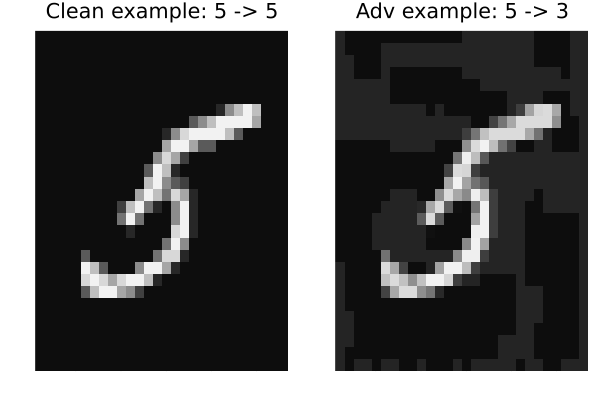

In [55]:
include("../src/utils/plot.jl")

idx = 7
difference = x_best[:, :, :, idx] - X_try[:, :, :, idx]
clean_pred_label = (model(X_try[:, :, :, idx:idx]) |> onecold |> getindex) - 1
adv_pred_label = (model(x_best[:, :, :, idx:idx]) |> onecold |> getindex) - 1
true_label = y_try[idx]
plot_mnist_image(x_best[:, :, :, idx], X_try[:, :, :, idx], clean_pred_label, adv_pred_label, true_label)